In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
import pickle

import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape, Dropout
from keras.models import Sequential

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
features = pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
fma_single = pickle.load(open("saved/fma_single.p", "rb"))

In [3]:
fma_multi=pickle.load(open("saved/fma_multi.p","rb"))

In [4]:
fma_multi.head()

,split,subset,filepath,genres_all,genre_top
track_id,,,,,
2,training,small,data/fma_large/000/000002.mp3,[21],Hip-Hop
3,training,medium,data/fma_large/000/000003.mp3,[21],Hip-Hop
5,training,small,data/fma_large/000/000005.mp3,[21],Hip-Hop
10,training,small,data/fma_large/000/000010.mp3,[10],Pop
20,training,large,data/fma_large/000/000020.mp3,"[17, 10, 76, 103]",NaN


For the baseline model we are going to use the 'small' set of 8000 tracks in 8 classes, and train the model on the mfccs of the tracks which we extracted earlier.

In [5]:
#load mfccs
mfcc_df=pickle.load(open("saved/mfcc_small.p","rb"))

In [6]:
mfcc_df.shape

(7997, 23232)

In [7]:
mfcc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23222,23223,23224,23225,23226,23227,23228,23229,23230,23231
2,-299.542053,-202.513412,-159.976059,-115.456413,-80.415161,-67.523239,-57.689404,-65.464790,-84.703659,-96.179939,...,-5.861199,-4.460218,-6.887738,-7.665272,6.717929,12.769140,11.439809,9.167293,7.916427,5.665779
5,-324.059723,-227.421249,-186.883606,-158.489868,-94.902466,-95.517578,-106.146324,-70.498611,-45.091522,-41.156029,...,-6.403229,-4.675876,5.932048,19.163589,24.138350,12.146925,1.931949,-0.370714,1.137535,-0.625799
10,-71.376122,-32.296730,-29.356266,-38.037708,-44.881695,-45.910717,-31.081173,8.275231,28.077381,6.006516,...,9.814901,0.409050,-6.546686,-4.728213,-2.329597,4.121199,8.337200,8.429386,10.133602,11.033691
140,-561.324280,-523.545837,-449.814423,-342.445557,-306.727356,-308.809631,-307.733276,-317.345245,-362.774811,-419.306946,...,1.818927,3.912658,4.593844,2.139801,-4.394735,-5.267244,-6.697974,-5.783470,-5.886441,-3.706590
141,-464.980743,-371.434326,-330.917175,-342.813904,-362.013550,-368.364441,-361.755188,-358.438049,-365.668640,-375.685730,...,0.601643,-0.995060,0.146230,3.676285,-1.177926,-2.822582,4.884428,3.736303,2.701882,-2.805002


In [8]:
#use the 8000 track balanced subset for baseline modeling
subset = fma_single.index[fma_single['subset'] == 'small']
tracks_sub=fma_multi.loc[subset]
mfcc_sub=mfcc_df.loc[subset]


In [9]:
#fill nan
mfcc_sub.fillna(value=0,inplace=True)

In [10]:
print(len(mfcc_sub),len(tracks_sub))

7997 7997


In [11]:
#use the built in train/test/validation split in case we want to compare to other models over this dataset
train = tracks_sub.index[tracks_sub['split'] == 'training']
val = tracks_sub.index[tracks_sub['split'] == 'validation']
test = tracks_sub.index[tracks_sub['split'] == 'test']

In [12]:
print(len(train),len(val),len(test))

6397 800 800


In [13]:
#preprocessing single label

#enc=MultiLabelBinarizer()
enc=LabelEncoder()
labels=tracks_sub['genre_top']
#labels=y_df

# Split in training, validation and testing sets.

#single label
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
#y_train = track_sub['label']

X_train = mfcc_sub.loc[train].values
X_val = mfcc_sub.loc[val].values
X_test = mfcc_sub.loc[test].values
    
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Standardize features
scaler =StandardScaler(copy=False)
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [14]:
%%time
clf=LogisticRegression(max_iter = 200, 
                       multi_class='multinomial',
                       n_jobs = -1)

clf.fit(X_train,y_train)

CPU times: user 167 ms, sys: 806 ms, total: 973 ms
Wall time: 2min 36s


LogisticRegression(max_iter=200, multi_class='multinomial', n_jobs=-1)

In [15]:
print('Classification Report (test set)')
print(classification_report(y_test,clf.predict(X_test)))

Classification Report (test set)
              precision    recall  f1-score   support

           0       0.28      0.34      0.31       100
           1       0.18      0.25      0.21       100
           2       0.15      0.13      0.14       100
           3       0.28      0.19      0.23       100
           4       0.22      0.23      0.23       100
           5       0.29      0.19      0.23       100
           6       0.11      0.10      0.10       100
           7       0.30      0.36      0.33       100

    accuracy                           0.22       800
   macro avg       0.23      0.22      0.22       800
weighted avg       0.23      0.22      0.22       800



In [16]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               11895296  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 12,068,296
Trainable params: 12,068,296
Non-trainable params: 0
_________________________________________________________________


In [17]:
%%time
history=model.fit(X_train,
          y_train,
          epochs=10,
          batch_size=256,
          validation_data=(X_val, y_val))

Train on 6397 samples, validate on 800 samples
Epoch 1/10
6397/6397 [==============================] - 1s 180us/step - loss: 2.5430 - accuracy: 0.2851 - val_loss: 1.9693 - val_accuracy: 0.2950
Epoch 2/10
6397/6397 [==============================] - 1s 122us/step - loss: 1.5525 - accuracy: 0.4610 - val_loss: 2.1106 - val_accuracy: 0.3350
Epoch 3/10
6397/6397 [==============================] - 1s 117us/step - loss: 1.1188 - accuracy: 0.6334 - val_loss: 2.0801 - val_accuracy: 0.3375
Epoch 4/10
6397/6397 [==============================] - 1s 119us/step - loss: 0.7259 - accuracy: 0.7897 - val_loss: 2.2033 - val_accuracy: 0.2975
Epoch 5/10
6397/6397 [==============================] - 1s 118us/step - loss: 0.4531 - accuracy: 0.8785 - val_loss: 2.3855 - val_accuracy: 0.3212
Epoch 6/10
6397/6397 [==============================] - 1s 120us/step - loss: 0.2811 - accuracy: 0.9329 - val_loss: 2.5739 - val_accuracy: 0.3137
Epoch 7/10
6397/6397 [==============================] - 1s 118us/step - loss:

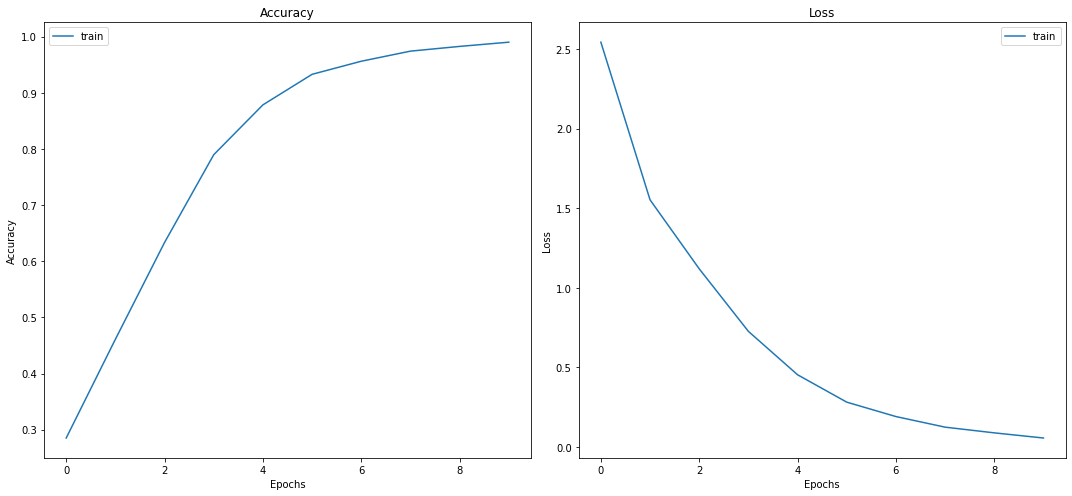

In [18]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
#make clear this is test set
y_pred=model.predict_classes(X_test)
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))

Classification Report (test set)
              precision    recall  f1-score   support

           0       0.34      0.35      0.34       100
           1       0.12      0.12      0.12       100
           2       0.20      0.20      0.20       100
           3       0.49      0.49      0.49       100
           4       0.35      0.41      0.38       100
           5       0.35      0.33      0.34       100
           6       0.15      0.14      0.15       100
           7       0.40      0.40      0.40       100

    accuracy                           0.30       800
   macro avg       0.30      0.30      0.30       800
weighted avg       0.30      0.30      0.30       800



Over the set of:  
* 8 classes
* 1000 samples each class

A baseline model of a fully connected neural net achieves better accuracy over the test set than a Logistic Regression.

| Model | Accuracy(all classes) | Train Time |
| --- | --- | --- |
| Logistic Regression | .22 | 2m 36s |
| Neural Net | .30 | 8.34s |


I will extend this model using more complicated neural net architectures as follows:
* Convolutiona Neural Net (CNN)
* Long Short Term Memory (LSTM)
* Combination architecture with both CNN and LSTM layers